# HLS项目：数字图像处理（DIP）系统
## 完成人：石尚轩、赵浩文
## 完成时间：2023.7.18

### 一. 项目介绍
图像处理系统封装了以下四个功能：
- 灰度变换 LinearTransform
- 图像滤波 MedianFilter
- 边缘检测 Sobel
- 图像分割 Threshold

### 二. 项目演示

### 2.1 加载图片

首先导入OpenCV-Python库用作图像处理，matplotlib库用作绘图。

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

处理的图片是灰度图片（1280*720），图片像素的灰度值存储在'data.txt'中，使用loadtxt方法读取，创建一个图片array，使用imshow显示

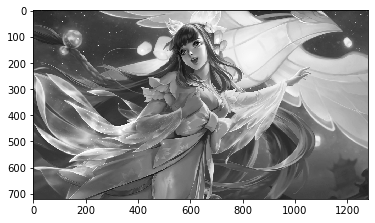

In [2]:
img = np.loadtxt('data.txt', dtype=int)
rows = 720
cols = 1280
img = img.reshape(rows, cols)
plt.imshow(img,cmap='gray')

再读取一张加入了噪声的图片，方法同上

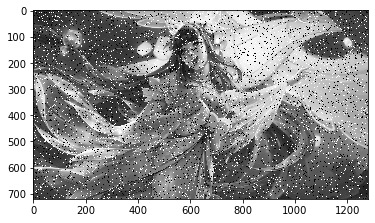

In [3]:
noise = np.loadtxt('noise.txt', dtype=int)
rows = 720
cols = 1280
noise = noise.reshape(rows, cols)
plt.imshow(noise,cmap='gray')

### 2.2 使用cpu处理图片

首先创建一张表来记录处理时间

In [4]:
import pandas as pd
# 创建数据
data = [
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0]
]
# 创建行和列的标签
rows = ['cpu', 'fpga']
cols = ['灰度变换', '中值滤波', '边缘检测', '阈值分割']

# 创建 DataFrame
df = pd.DataFrame(data, index=rows, columns=cols)
df

,灰度变换,中值滤波,边缘检测,阈值分割
cpu,0.0,0.0,0.0,0.0
fpga,0.0,0.0,0.0,0.0


分别测试在cpu下，处理图片所需要的时间

（1）灰度变换测试

耗时：0.06370854377746582s


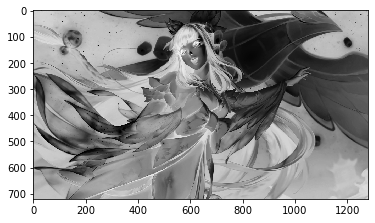

In [5]:
import time

# 定义线性变换的参数
a = -1  # 斜率
b = 255   # 截距

start_time = time.time()
transformed_img = a * img + b # 执行线性变换
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))
df['灰度变换']['cpu'] = end_time - start_time
plt.imshow(transformed_img,cmap='gray')

（2）中值滤波测试

耗时：0.8105041980743408s


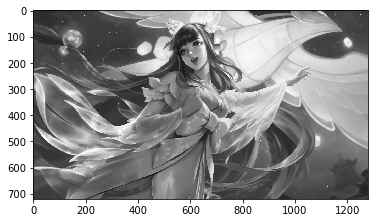

In [6]:
import scipy.ndimage as ndimage

# 定义中值滤波的核大小
kernel_size = 3

start_time = time.time()
filtered_img = ndimage.median_filter(noise, size=kernel_size)# 执行中值滤波
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))
df['中值滤波']['cpu'] = end_time - start_time
plt.imshow(filtered_img,cmap='gray')

（3）Sobel边缘检测测试

耗时：0.9944343566894531s


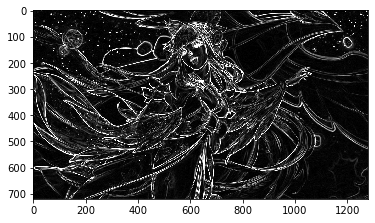

In [7]:
start_time = time.time()
# 执行 Sobel 边缘检测
sobel_x = ndimage.sobel(img, axis=0)
sobel_y = ndimage.sobel(img, axis=1)
# 计算边缘强度
edge_strength = np.hypot(sobel_x, sobel_y)
# 将边缘强度限制在 0 到 255 之间
edge_strength = np.clip(edge_strength, 0, 255)
# 将浮点数转换为整数
edge_strength = edge_strength.astype(np.uint8)

end_time = time.time()
print("耗时：{}s".format(end_time - start_time))
df['边缘检测']['cpu'] = end_time - start_time
plt.imshow(edge_strength,cmap='gray')

（4）阈值分割测试

耗时：0.06619000434875488s


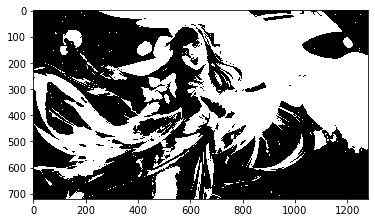

In [8]:
start_time = time.time()
# 定义阈值
threshold = 125
# 执行阈值分割
segmented_img = np.where(img >= threshold, 255, 0)
# 将数据类型转换为无符号8位整数
segmented_img = segmented_img.astype(np.uint8)
end_time = time.time()
print("耗时：{}s".format(end_time - start_time))
df['阈值分割']['cpu'] = end_time - start_time
plt.imshow(segmented_img,cmap='gray')

测试完毕，查看一下cpu处理这些任务所需要的时间

In [9]:
df

,灰度变换,中值滤波,边缘检测,阈值分割
cpu,0.063709,0.810504,0.994434,0.06619
fpga,0.000000,0.000000,0.000000,0.00000


### 2.3 使用fpga加速图片处理

#### 载入Overlay

In [10]:
from pynq import Overlay, allocate

overlay = Overlay("./DIP.bit")

DIP = overlay.DIP_0

#### 将硬件设计部署到板卡上，根据图片尺寸分配内存，并将图像复制到对应位置。

In [11]:
rows = 720
cols = 1280

# allocate memory
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
gray_new = np.uint8(img)
np.copyto(input_buffer, gray_new.flatten())

In [12]:
input_buffer

PynqBuffer([56, 56, 57, ..., 50, 50, 48], dtype=uint8)

这里介绍一下在HLS中的Top模块，DIP通过mode的值（0~3）来判断当前的任务
![HLS中封装的Top模块](Top.jpg)

#### 为IP创建一个Driver，将传递参数、启动、计时等操作封装起来，方便直接调用

In [13]:
def DipDriver(mode, k, b):
    #设置参数
    DIP.register_map.rows = rows
    DIP.register_map.cols = cols
    DIP.register_map.mode = mode
    DIP.register_map.b = b
    DIP.register_map.k = k 
    #将IP中的DMA对象提取出来
    dma = overlay.axi_dma_0
    #启动IP
    DIP.register_map.CTRL.AP_START = 1
    start_time = time.time()
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait() # wait for send channel
    dma.recvchannel.wait() # wait for recv channel
    end_time = time.time()
    
    return end_time - start_time #返回时间

#### 调用driver，依次测试fpga处理图像所需的时间

#### （1）灰度变换测试，模式0，这里k=-1，b=255，达到了颜色反转的效果

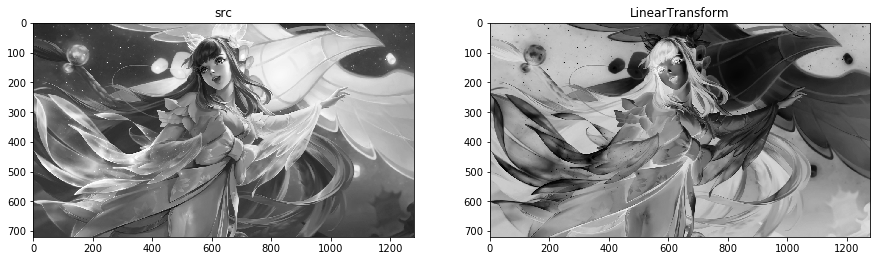

In [14]:
gray_new = np.uint8(img)
np.copyto(input_buffer, gray_new.flatten()) #设置Input
df['灰度变换']['fpga'] = DipDriver(0,-1,255) #调用Driver
#绘制图像
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(15)
fig_1 = fig.add_subplot(121)
fig_1.title.set_text('src')
plt.imshow(img,cmap='gray')
fig_2 = fig.add_subplot(122)
fig_2.title.set_text('LinearTransform')
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')

#### （2）中值滤波测试，模式1，达到了去噪的效果

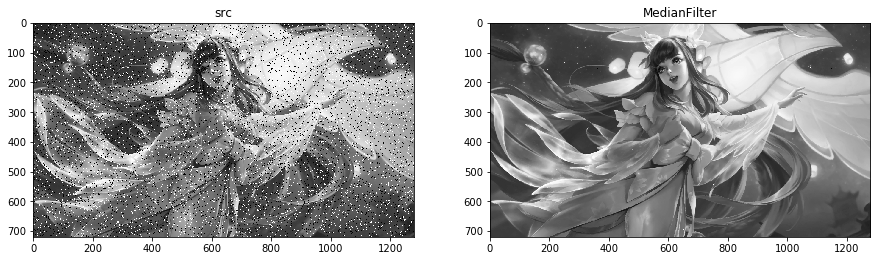

In [15]:
gray_new = np.uint8(noise)
np.copyto(input_buffer, gray_new.flatten())  #设置Input
df['中值滤波']['fpga'] = DipDriver(1,0,0) #调用Driver
#绘制图像
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(15)
fig_1 = fig.add_subplot(121)
fig_1.title.set_text('src')
plt.imshow(noise,cmap='gray')
fig_2 = fig.add_subplot(122)
fig_2.title.set_text('MedianFilter')
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')

#### （3）边缘检测测试，模式2

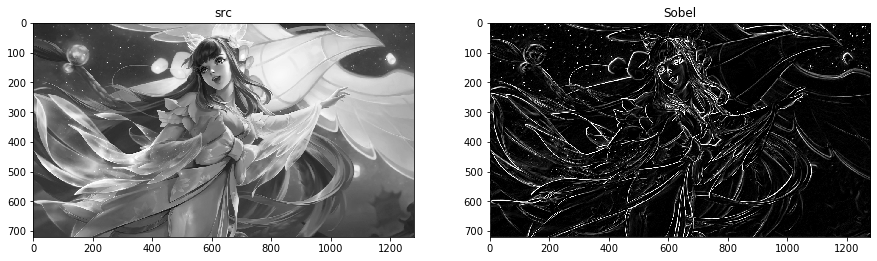

In [16]:
gray_new = np.uint8(img)
np.copyto(input_buffer, gray_new.flatten())  #设置Input
df['边缘检测']['fpga'] = DipDriver(2,0,0) #调用Driver
#绘制图像
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(15)
fig_1 = fig.add_subplot(121)
fig_1.title.set_text('src')
plt.imshow(img,cmap='gray')
fig_2 = fig.add_subplot(122)
fig_2.title.set_text('Sobel')
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')

#### （4）阈值分割测试，模式3，这里阈值b=120

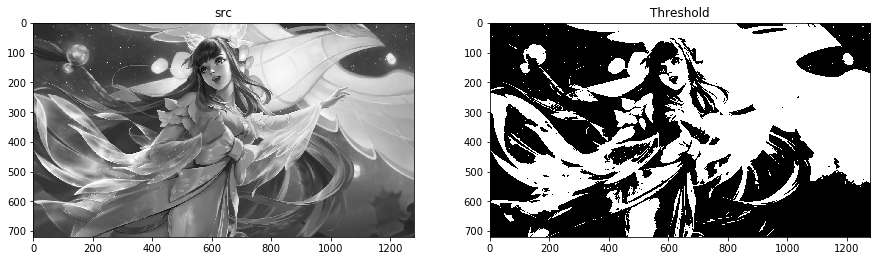

In [17]:
gray_new = np.uint8(img)
np.copyto(input_buffer, gray_new.flatten())  #设置Input
df['阈值分割']['fpga'] = DipDriver(3,0,120) #调用Driver
#绘制图像
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(15)
fig_1 = fig.add_subplot(121)
fig_1.title.set_text('src')
plt.imshow(img,cmap='gray')
fig_2 = fig.add_subplot(122)
fig_2.title.set_text('Threshold')
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')

### 2.4 FPGA加速效果展示

打印df，可以看到fpga的加速效果，在灰度变换、阈值分割这种简单的任务上，fpga的速度是cpu的两倍；在中值滤波、边缘检测这类较复杂的任务上，fpga由于其并行计算的优势，速度大大领先于cpu，起到了很好的加速效果。本项目实验成功！

In [18]:
df

,灰度变换,中值滤波,边缘检测,阈值分割
cpu,0.063709,0.810504,0.994434,0.066190
fpga,0.031092,0.031049,0.030859,0.030693
